# Programming Exercise 3: Multi-class Classification and Neural Networks

> In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## 1. Multi-class Classification

> For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.
In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

> You are given a data set in ex3data1.mat that contains 5000 training examples of handwritten digits,  where each training example is a 20 pixel by 20 pixel grayscale image of the digit.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.io
mat = scipy.io.loadmat('data/ex3data1.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

### 1.2 Visualizing the Data

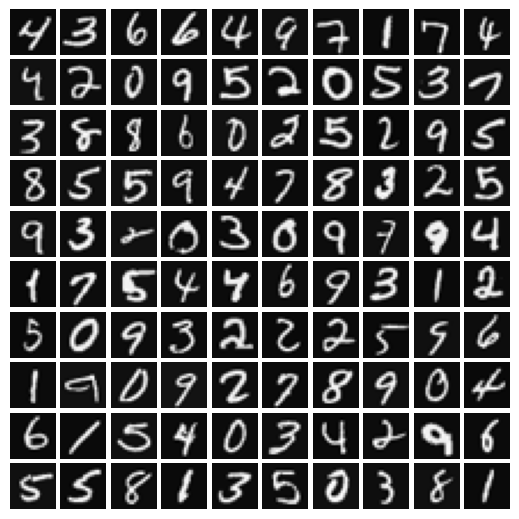

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Define the number of rows and columns in the grid of images
rows = 10
cols = 10
# Create a figure object with a specified size
fig = plt.figure(figsize=(5,5))
# Randomly select indexes from the range [0, 5000) to display images
indexes = np.random.choice(5000, rows*cols)
# Initialize a counter to keep track of the index of the current image
count = 0
# Loop through each row
for i in range(0, rows):
    # Loop through each column
    for j in range(0, cols):
        # Add a subplot to the figure grid at the current index position
        ax1 = fig.add_subplot(rows, cols, count+1)
        # Display the image corresponding to the randomly selected index
        # Reshape the image to a 20x20 matrix and transpose it
        ax1.imshow(mat['X'][indexes[count]].reshape(20,20).T, cmap='gray')
        # Turn off autoscaling of the axes
        ax1.autoscale(False)
        # Hide the axes
        ax1.set_axis_off()
        # Increment the counter
        count += 1

# Adjust the spacing between subplots and margins of the figure
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
# Display the figure with all subplots
plt.show()

### 1.3 Vectorizing Logistic Regression

#### 1.3.1 Vectorizing Regularized Logistic Regression

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^m[y^i log(h_\theta(x^i))+(1-y^i)log(1-h_\theta(x^i))] + \frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$$

Gradient:

$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)} - y^{(i)})\cdot x_j^{(i)} \ \text{for j=0}$$

$$\frac{\partial J(\theta)}{\partial \theta_0} = (\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)} - y^{(i)})\cdot x_j^{(i)}) + \frac{\lambda}{m}\theta_j \ \text{for j$\ge$1}$$

Recall that:

$h_\theta(x^{(i)}) = g(\theta^Tx^{(i)})$

$g(z) = \frac{1}{1+e^{-z}}$


In [10]:
import numpy as np  # Import the NumPy library and alias it as np

def sigmoid(z):  # Define a function named sigmoid that takes one argument z
    z = np.array(z)  # Convert the input z into a NumPy array
    return 1 / (1 + np.exp(-z))  # Compute the sigmoid function for each element of z

In [11]:
def lr_cost_function(theta, X, y, lambda_reg):
    m = y.shape[0]  # Number of training examples
    theta = theta[:, np.newaxis]  # Reshape theta to ensure it's a column vector
    h = sigmoid(X.dot(theta))  # Calculate the hypothesis using the sigmoid function
    # Compute the cost function J(theta)
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h))) + (lambda_reg/(2*m)) * np.sum(theta[1:]**2)
    
    # Compute the difference between hypothesis and actual values
    diff_hy = h - y
    # Compute the gradient of the cost function with respect to theta
    grad = (1/m) * diff_hy.T.dot(X) + ((lambda_reg/m) * theta.T)
    grad[0, 0] = (1/m) * diff_hy.T.dot(X[:, 0])  # Adjust gradient for the intercept term
    
    return J, grad  # Return the cost and gradient


Testing Cost Function

In [12]:
# Define test values for theta, X, y, and lambda
theta_t = np.array([-2, -1, 1, 2])  # Example theta values
X_t = np.hstack((np.ones((5,1)), (np.arange(1,16).reshape(3,5)).T / 10))  # Example feature matrix X
y_t = np.array([1, 0, 1, 0, 1]).reshape(5, -1)  # Example target values y
lambda_t = 3  # Example regularization parameter lambda


In [8]:
J, grad = lr_cost_function(theta_t, X_t, y_t, lambda_t)
print('Cost:', J)
print('Expected cost: 2.534819')
print('Gradients:')
print(grad.T)
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003')

Cost: [[2.5348194]]
Expected cost: 2.534819
Gradients:
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


### 1.4 One-vs-all Classification

> In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of K.

In [13]:
import scipy.optimize as opt  # Import the optimization module from scipy library

def one_vs_all(X, y, num_labels, lambda_reg):
    m, n = X.shape  # Get the number of training examples and features
    all_theta = np.zeros((num_labels, n+1))  # Initialize matrix to store parameters for each class
    
    # Add intercept term to the feature matrix X
    X = np.hstack((np.ones((m,1)), X))
    
    # Loop through each class
    for i in range(num_labels):
        initial_theta = np.zeros(shape=(n+1))  # Initialize theta for current class
        # Use optimization to find optimal theta for current class
        opt_results = opt.minimize(lr_cost_function, initial_theta, args=(X, y==i+1, lambda_reg), 
                                   method='TNC', jac=True, options={'maxiter':50})
        all_theta[i, :] = opt_results['x']  # Store optimal theta for current class
        
    return all_theta  # Return matrix containing all theta values for each class


#### 1.4.1 One-vs-all Prediction

In [14]:
def predict_one_vs_all(all_theta, X):
    m, n = X.shape  # Get the number of examples and features
    X = np.hstack((np.ones((m,1)),X))  # Add intercept term to the feature matrix
    
    # Calculate the probabilities for each class
    pred = sigmoid(X.dot(all_theta.T))
    
    # Choose the class with the highest probability as the predicted class
    y_pred = np.argmax(pred, axis=1) + 1
    
    return y_pred  # Return the predicted class labels


In [17]:
lambda_r = 0.1  # Regularization parameter
num_labels = 10  # Number of labels or classes

# Call the 'one_vs_all' function to train the classifier
# 'mat['X']' contains the feature matrix
# 'mat['y']' contains the target labels
# 'num_labels' is the number of classes
# 'lambda_r' is the regularization parameter
all_theta = one_vs_all(mat['X'], mat['y'], num_labels, lambda_r)


/tmp/ipykernel_501179/1737659423.py:14: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  opt_results = opt.minimize(lr_cost_function, initial_theta, args=(X, y==i+1, lambda_reg),


In [20]:
# Use the trained 'all_theta' parameters to predict labels for the training data
y_pred = predict_one_vs_all(all_theta, mat['X'])

# Calculate the accuracy by comparing the predicted labels with the actual labels
accuracy = np.mean(y_pred == mat['y'].T)

# Format the accuracy as a percentage string
result = f'Train accuracy: {accuracy * 100}'
print(result)

Train accuracy: 95.28


#### 1.4.2 Similar Code using Scikit-Learn:

In [21]:
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression model from scikit-learn

# Create a Logistic Regression model object with specified parameters
# 'solver='newton-cg'' sets the optimization algorithm to Newton's conjugate gradient method
# 'max_iter=50' sets the maximum number of iterations for optimization
# 'multi_class='ovr'' specifies the one-vs-rest strategy for multi-class classification
log_reg = LogisticRegression(solver='newton-cg', max_iter=50, multi_class='ovr')

# Train the Logistic Regression model on the feature matrix 'mat['X']' and target labels 'mat['y']'
# 'mat['y'].T[0]' reshapes the target labels to be a 1-dimensional array
log_reg.fit(mat['X'], mat['y'].T[0])


LogisticRegression(max_iter=50, multi_class='ovr', solver='newton-cg')

In [14]:
log_reg.score(mat['X'], mat['y'].T[0])

0.9446

## 2. Neural Networks

> In this part of the exercise, you will implement a neural network to rec- ognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s ex- ercise, you will write the backpropagation algorithm for learning the neural network parameters.

### 2.1 Model Representation

<img src="neural_network.png">

> You have been provided with a set of network parameters $(\Theta^{(1)},\Theta^{(2)})$ already trained by us.

In [22]:
mat_weights = scipy.io.loadmat('data/ex3weights.mat')

In [23]:
mat_weights['Theta1'].shape, mat_weights['Theta2'].shape

((25, 401), (10, 26))

### 2.2 Feedforward Propagation and Prediction

The formulas to find $h_\theta(x^{(i)})$ are in the neural network figure above.

In [24]:
def predict_nn(theta1, theta2, X):
    m, n = X.shape  # Get the number of examples and features
    a1 = np.hstack((np.ones((m,1)), X))  # Add intercept term to the input layer
    
    z2 = a1.dot(theta1.T)  # Calculate the input to the hidden layer
    a2 = sigmoid(z2)  # Compute the activation of the hidden layer
    
    # Add intercept term to the hidden layer
    a2_with_bias = np.hstack((np.ones((m,1)), a2))
    
    z3 = a2_with_bias.dot(theta2.T)  # Calculate the input to the output layer
    a3 = sigmoid(z3)  # Compute the activation of the output layer
    
    # Determine the predicted class label for each example
    h = np.argmax(a3, axis=1) + 1
    
    return h  # Return the predicted class labels


In [26]:
# Use the trained neural network parameters to predict labels for the training data
y_pred = predict_nn(mat_weights['Theta1'], mat_weights['Theta2'], mat['X'])

# Calculate the accuracy by comparing the predicted labels with the actual labels
accuracy = np.mean(y_pred == mat['y'].T)

# Format the accuracy as a percentage string
result = f'Train accuracy: {accuracy * 100}'
result

'Train accuracy: 97.52'

### 2.2.1 Similar Code using Scikit-Learn:

In [29]:
from sklearn.neural_network import MLPClassifier  # Import Multi-Layer Perceptron classifier from scikit-learn

# Create a Multi-Layer Perceptron (MLP) classifier object with specified parameters
# 'hidden_layer_sizes=(25,)' sets the number of neurons in the hidden layer to 25
# 'activation='logistic'' sets the activation function for the hidden layer to logistic (sigmoid)
nn = MLPClassifier(hidden_layer_sizes=(25,), activation='logistic')

# Train the MLP classifier on the feature matrix 'mat['X']' and target labels 'mat['y']'
# 'mat['y'].T[0]' reshapes the target labels to be a 1-dimensional array
nn.fit(mat['X'], mat['y'].T[0])


/home/muhammad/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(25,))

In [31]:
nn.score(mat['X'], mat['y'].T[0])

0.988